# 1. SETTINGS

In [26]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.metrics import log_loss
from sklearn.neighbors import NearestNeighbors
import copy
import scipy.stats
import os
import time

In [27]:
# pandas options
pd.set_option('display.max_columns', None)

In [28]:
# dark background style
plt.style.use('dark_background')

In [29]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [30]:
# garbage collection
import gc
gc.enable()

In [31]:
# helper functions
import functions
from functions import *

# 2. DATA PREPARATION

In [32]:
# import CSV
df = pd.read_csv('../data/data_v2.csv')
print(df.shape)

(11840, 154)


In [33]:
# target variable
target = 'duration'

In [34]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(8880, 154)
(2960, 154)


In [35]:
# target variable
y = train[target]
del train[target], test[target]
classes = y.unique()
classes

array([2., 1., 0.])

# 3. MODELING

### PARAMETERS

In [36]:
# drop bad features
excluded_feats = ['id', 'image_url', 'product_description']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(8880, 151)


In [37]:
### PARAMETERS

# settings
cores = -1
seed  = 4

# cross-validation
num_folds = 5
shuffle   = True

# muner of rounds
max_rounds = 1000
stopping   = 200
verbose    = 200

# LGB parameters
lgb_params = {
    'boosting_type':     'gbdt',
    'objective':         'multiclass',
    'metric':            'multi_logloss',
    'num_class':         len(classes),
    'bagging_fraction':  0.9,
    'feature_fraction':  0.9,
    'lambda_l1':         0.1,
    'lambda_l2':         0.1,
    'min_split_gain':    0,
    'min_child_weight':  0.1,
    'min_child_samples': 20,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.03,
    'max_depth':         5,
    'num_leaves':        50,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [38]:
# placeholders
clfs = []
valid_perf  = np.zeros(num_folds) 
importances = pd.DataFrame()

#preds_test   = np.zeros(test.shape[0])
#preds_oof    = np.zeros(train.shape[0])

preds_oof  = np.zeros((len(train), len(classes)))
preds_test = np.zeros((len(test),  len(classes)))

In [39]:
# SMOTE settings
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = 23, n_jobs = 10, sampling_strategy = 0.1)

### CROSS-VALIDATION

In [40]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    test_x       = test[features]
    
    ## remove outliers
    #out_idx = (np.abs(scipy.stats.zscore(trn_x)) < 10).all(axis = 1)
    #trn_x = trn_x[out_idx]
    #trn_y = trn_y[out_idx]
    
    # scale data
    #scaler   = RobustScaler()
    #trn_x    = pd.DataFrame(scaler.fit_transform(trn_x), columns = features)
    #val_x    = pd.DataFrame(scaler.transform(val_x),     columns = features)
    #tmp_test = pd.DataFrame(scaler.transform(test_x),    columns = features)

    # augment training data with SMOTE
    #trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    #trn_x = pd.DataFrame(trn_x, columns = features)
    #trn_y = pd.Series(trn_y)
       
    # add noise to train to reduce overfitting
    #trn_x += np.random.normal(0, 0.01, trn_x.shape)
    
    # mean target encoding
    #trn_x, val_x, test_x = mean_target_encoding(trn_x, val_x, test, features = ['trustLevel'], target = 'fraud', folds = 5)
    #features = [f for f in trn_x.columns if f not in excluded_feats]
        
    # train lightGBM
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = clf.best_iteration_
       
    
############ PERFORM 1 ITERATRION OF SELF-TRAINING
#
#    # predict unlabeled data
#    tmp_preds_test = clf.predict_proba(tmp_test, num_iteration = best_iter)[:, 1]
#
#    # extract most confident preds
#    perc_ones  = 0.0001
#    perc_zeros = 0.0001
#    pmax = np.quantile(tmp_preds_test, 1 - perc_ones)
#    pmin = np.quantile(tmp_preds_test, perc_zeros)
#    tmp_preds_test[tmp_preds_test >= pmax] = 1
#    tmp_preds_test[tmp_preds_test <= pmin] = 0
#    confident_ones  = np.where(tmp_preds_test == 1)
#    confident_zeros = np.where(tmp_preds_test == 0)
#    confident_ones  = confident_ones[0][0:np.round(len(tmp_test)  * perc_ones).astype('int')]
#    confident_zeros = confident_zeros[0][0:np.round(len(tmp_test) * perc_zeros).astype('int')]
#    confident_idx   = np.concatenate((confident_ones, confident_zeros))
#
#    # append new data to train
#    test_X = tmp_test.iloc[confident_idx]
#    test_y = pd.Series(tmp_preds_test[confident_idx])
#    trn_x  = trn_x.append(test_X)
#    trn_y  = trn_y.append(test_y)
#    print('--------------------------------')
#    print('Added %.0f cases to training data...' % len(test_y))
#    print('--------------------------------')
#
#    # retrain lightGBM
#    print('Custom early stopping: select the best out of %.0f iterations...' % max_rounds)
#    clf = lgb.LGBMClassifier(**lgb_params) 
#    clf = clf.fit(trn_x, trn_y, 
#                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
#                  eval_metric           = prediction_reward, 
#                  verbose               = verbose)
#
#    # find the best iteration
#    best_iter = np.argmax(clf.evals_result_['valid_1']['profit']) + 1
#    print('Best iteration is:')
#    print('[' + str(best_iter) + ']   valid_1 profit: ' + 
#          str(prediction_reward(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1])[1].astype('int')) + 
#          "; log_loss = ", str(np.round(log_loss(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1]), 6)))
#    
############ PERFORM 1 ITERATRION OF SELF-TRAINING


    # save predictions
    #preds_oof[val_idx]    = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
    #valid_profit[n_fold]  = log_loss(y, preds_oof)
    #preds_test           += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 
    
    # save predictions
    preds_oof[val_idx, :] = clf.predict_proba(val_x, num_iteration = best_iter)
    valid_perf[n_fold]    = log_loss(y[val_idx], preds_oof[val_idx, :])
    preds_test           += clf.predict_proba(test_x, num_iteration = best_iter) / folds.n_splits 

    # importance
    fold_importance_df               = pd.DataFrame()
    fold_importance_df['Feature']    = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold']       = n_fold + 1
    importances                      = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: LOGLOSS = %.6f' % (n_fold + 1, valid_perf[n_fold]))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    # uncomment for mean target encoding
    #features = [f for f in train.columns if f not in excluded_feats]
    
    
# print overall performance    
cv_perf = np.mean(valid_perf)
print('--------------------------------')
print('MEAN LOGLOSS = %.6f' % cv_perf)
print('--------------------------------')

Training until validation scores don't improve for 200 rounds.
[200]	training's multi_logloss: 0.868248	valid_1's multi_logloss: 0.963842
[400]	training's multi_logloss: 0.786407	valid_1's multi_logloss: 0.950021
[600]	training's multi_logloss: 0.718207	valid_1's multi_logloss: 0.94464
[800]	training's multi_logloss: 0.656875	valid_1's multi_logloss: 0.944475
[1000]	training's multi_logloss: 0.603919	valid_1's multi_logloss: 0.942052
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.603919	valid_1's multi_logloss: 0.942052
--------------------------------
FOLD 1: LOGLOSS = 0.942052
--------------------------------

Training until validation scores don't improve for 200 rounds.
[200]	training's multi_logloss: 0.864235	valid_1's multi_logloss: 0.978452
[400]	training's multi_logloss: 0.779956	valid_1's multi_logloss: 0.969526
[600]	training's multi_logloss: 0.709864	valid_1's multi_logloss: 0.966974
[800]	training's multi_logloss: 0.648869	valid_1's multi

In [41]:
##### RECHECK PERFORMANCE  
np.round(log_loss(y, preds_oof), 6)


###### TRACKING RESULTS (5 folds, strat = True, seed = 4)

# V1: 

0.959967

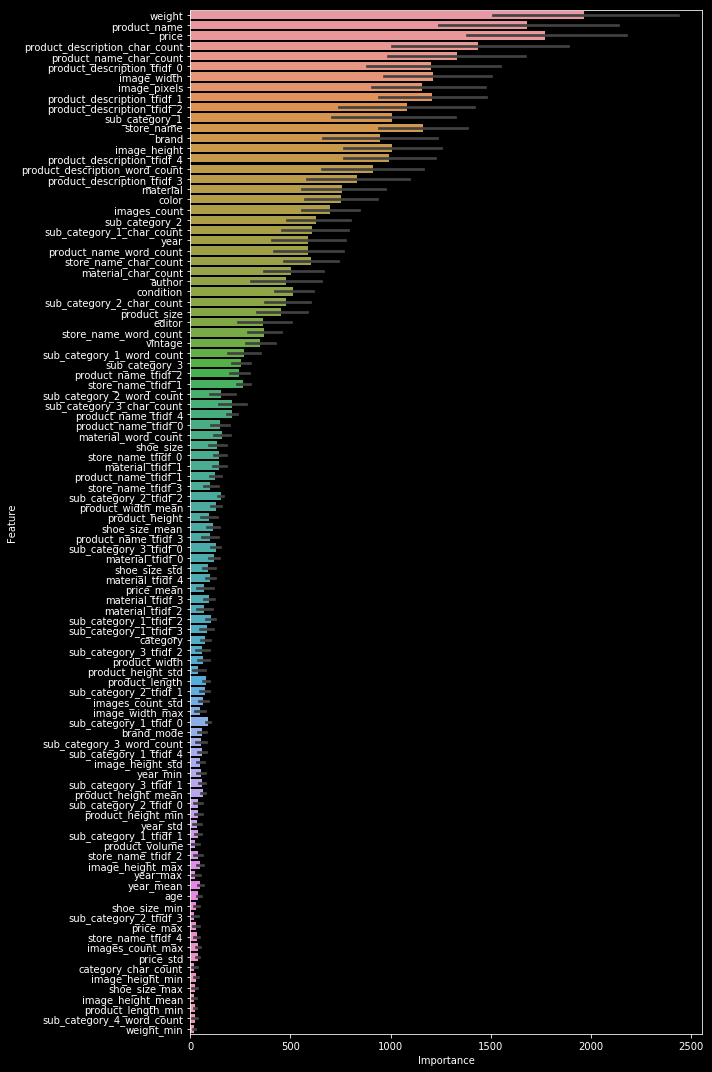

In [42]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 100
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 15))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()

# save plot as pdf
plt.savefig('../var_importance.pdf')

# 4. SUBMISSION

In [43]:
# file name
model = 'lgb_v1'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf

In [44]:
# export OOF preds
#oof = pd.DataFrame({'id': train['id'], 'duration': preds_oof})
#oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
#oof.head()

In [45]:
# export submission
#sub = pd.DataFrame({'id': test['id'], 'duration': preds_test})
#sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
#sub.head()

In [46]:
# export OOF preds
oof = pd.DataFrame(preds_oof)
oof.insert(0, column = 'id', value = train['id'].reset_index(drop = True))
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,id,0,1,2
0,0,0.651035,0.150595,0.198370
1,1,0.761877,0.178317,0.059807
2,2,0.504453,0.106356,0.389190
3,3,0.341041,0.294068,0.364891
4,4,0.617193,0.243074,0.139732


In [47]:
# export submission
sub = pd.DataFrame(preds_test)
sub.insert(0, column = 'id', value = test['id'].reset_index(drop = True))
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.head()

,id,0,1,2
0,0,0.209232,0.352796,0.437972
1,1,0.422065,0.222439,0.355496
2,2,0.204500,0.776318,0.019182
3,3,0.204862,0.304400,0.490738
4,4,0.570115,0.191943,0.237942


In [48]:
# check correlation with previous submission
#prev_sub = pd.read_csv('../submissions/lgb_v8_375.csv')
#cor = np.sum(prev_sub[target] == sub.reset_index()[target]) / len(sub)
#print("Share of the same predictions: " + str(np.round(cor, 6)))

In [ ]:
# check correlation with previous submission
prev_sub = pd.read_csv('../submissions/lgb_v1_96790.csv')
pd.Series(np.diag(sub.apply(lambda x: prev_sub.corrwith(x))))

In [ ]:
# submit to QSCORE
comment = ''
submit_prediction(sub, sep = ',', index = False, comment = str(comment) + ' - ' + name)